In [39]:
import pandas as pd
from pathlib import Path

# Requires scikitmol (https://github.com/EBjerrum/scikit-mol)
from scikit_mol.standardizer import Standardizer
from scikit_mol.fingerprints import MorganFingerprintTransformer
from scikit_mol.descriptors import MolecularDescriptorTransformer
from rdkit import Chem

from sklearn.metrics import recall_score, accuracy_score, precision_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from xgboost import XGBClassifier

DATA_DIR = Path("data/processed")
RANDOM_STATE = 42

In [7]:
df = pd.read_csv(DATA_DIR/"smiles_aggregated.csv")
df.head()

,mol,CID,Class,Model,pIC50,MW,AlogP,HBA,HBD,RB,...,PEOE6 (PEOE6),PEOE7 (PEOE7),PEOE8 (PEOE8),PEOE9 (PEOE9),PEOE10 (PEOE10),PEOE11 (PEOE11),PEOE12 (PEOE12),PEOE13 (PEOE13),PEOE14 (PEOE14),canvasUID
0,O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...,BACE_1,1,Train,9.154901,431.56979,4.4014,3,2,5,...,53.205711,78.640335,226.85541,107.43491,37.133846,0.000000,7.980170,0.0,0.000000,1
1,Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...,BACE_2,1,Train,8.853872,657.81073,2.6412,5,4,16,...,73.817162,47.171600,365.67694,174.07675,34.923889,7.980170,24.148668,0.0,24.663788,2
2,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_3,1,Train,8.698970,591.74091,2.5499,4,3,11,...,70.365707,47.941147,192.40652,255.75255,23.654478,0.230159,15.879790,0.0,24.663788,3
3,S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...,BACE_4,1,Train,8.698970,591.67828,3.1680,4,3,12,...,56.657166,37.954151,194.35304,202.76335,36.498634,0.980913,8.188327,0.0,26.385181,4
4,S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...,BACE_5,1,Train,8.698970,629.71283,3.5086,3,3,11,...,78.945702,39.361153,179.71288,220.46130,23.654478,0.230159,15.879790,0.0,26.100143,5


<AxesSubplot: >

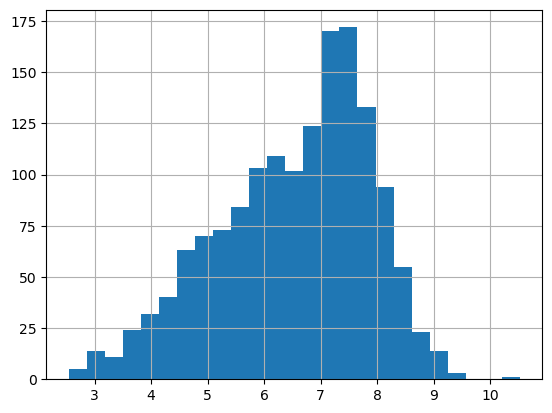

In [11]:
df["pIC50"].hist(bins=25)

### Standardize smiles codes

In [16]:
standardizer = Standardizer()
smiles = df["mol"].tolist()
mols = [Chem.MolFromSmiles(item) for item in smiles]
molss = standardizer.transform(mols)

### Targets

In [18]:
threshold_pIC50 = 6
y = [1 if item < threshold_pIC50 else 0 for item in df["pIC50"].tolist()]

Text(0.5, 1.0, 'Target distribution')

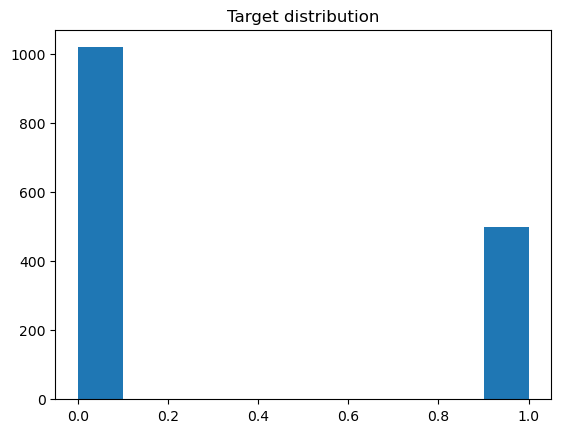

In [23]:
_ = plt.hist(y)
plt.title("Target distribution")

### Train/test split

In [27]:
mol_train, mol_test, y_train, y_test = train_test_split(molss, y, test_size=0.1, random_state=RANDOM_STATE)

## Molecular fingerprints case

### Pipeline definition

In [70]:
n_components = 64
# pipeline 1: based exclusively on molecular fingerprints
p = Pipeline([('mol_transformer', MorganFingerprintTransformer()), ('PCA', PCA(n_components=n_components)), ('Classifier', XGBClassifier())])

### Fit the pipeline

In [71]:
p.fit(mol_train, y_train)
y_pred = p.predict(mol_test)

In [72]:
print("Sensitivity: "+str(recall_score(y_test, y_pred)))
print("Specificity: "+str(recall_score(y_test, y_pred, pos_label=0)))
print("Precision: "+str(precision_score(y_test, y_pred)))


Sensitivity: 0.7333333333333333
Specificity: 0.897196261682243
Precision: 0.75


## Molecular descriptor case

In [73]:
descriptor = MolecularDescriptorTransformer()
available_descriptors = descriptor.available_descriptors
print(f"There are {len(available_descriptors)} available descriptors")
print(f"The first five descriptor names: {available_descriptors[:5]}")

There are 208 available descriptors
The first five descriptor names: ['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed']


### Pipeline definition

In [74]:
QED_descriptors = ["ExactMolWt", "MolLogP", "NumHAcceptors", "NumHDonors", "TPSA", "NumRotatableBonds", "NumAromaticRings"]
p = Pipeline([('mol_transformer', MolecularDescriptorTransformer(desc_list=QED_descriptors)), ('Classifier', XGBClassifier())])

### Fit the pipeline

In [75]:
p.fit(mol_train, y_train)
y_pred = p.predict(mol_test)

In [76]:
print("Sensitivity: "+str(recall_score(y_test, y_pred)))
print("Specificity: "+str(recall_score(y_test, y_pred, pos_label=0)))
print("Precision: "+str(precision_score(y_test, y_pred)))

Sensitivity: 0.7333333333333333
Specificity: 0.9065420560747663
Precision: 0.7674418604651163
